In [1]:
# # Configuration related preprocessing step before mounting the drive
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [2]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import Necessary libraries
import os 

# Set Directory path for Dataset
os.chdir("/content/drive/My Drive/")

In [4]:
import pandas as pd
import numpy as np
data = pd.read_csv('Final Dataset NEWSPAPERBD.csv')

In [5]:
data

,Url,News Paper Name,Publish Date,State,City,Country,Headline of the article in Bengali,Headline of the article in English,Text of the Article,Summarry of the Article,Category,Sub-category
0,https://www.thedailystar.net/coronavirus-updat...,The Daily Star,2020-05-13 13:28:15+06:00,Chittagong,Chittagong,Bangladesh,একদিনে কোভিড -১৯ এর সর্বোচ্চ সংখ্যা,Highest number of Covid-19 deaths in a day,Nineteen people -- the highest number in 24 ho...,Nineteen people -- the highest number in 24 ho...,Statistics,NaN
1,https://www.thedailystar.net/country/news/thro...,The Daily Star,2020-05-13 00:00:00+06:00,Dhaka,Dhaka,Bangladesh,"চাকরি থেকে ছিটকে পড়ে, টাঙ্গাইলের চামচাম নির্ম...","Thrown out of job, Tangail’s chamcham makers p...",Around 1000 workers engaged in producing chamc...,As the chamcham shops are closed due to the lo...,COVID-19 Effects,Global economic impact of Corona virus
2,https://www.thedailystar.net/country/news/copi...,The Daily Star,2020-05-13 00:00:00+06:00,Chittagong,Chittagong,Bangladesh,কোভিড -১৯ শাটডাউন মোকাবেলা: ২০০ পরিবার উদ্যানে...,Coping with Covid-19 Shutdown: 200 families re...,Family squabbles were becoming all too common ...,"The volunteer students, under the banner 'Sabu...",Social Information,Social impact
3,https://www.thedailystar.net/country/news/7-fa...,The Daily Star,2020-05-12 23:00:04+06:00,Dhaka,Dhaka,Bangladesh,"বগুড়ার কোভিড -১৯ এর জন্য সাত পরিবারের সদস্য, ...","7 family members, 4 police personnel test posi...",At least eleven people tested positive for cor...,At least eleven people tested positive for cor...,COVID-19 Effects,Positive patient symptoms and identification
4,https://www.thedailystar.net/coronavirus-updat...,The Daily Star,2020-05-12 21:27:34+06:00,Dhaka,Dhaka,Bangladesh,করোনাভাইরাস: স্বাস্থ্য মন্ত্রনালয় সরকারি কর্ম...,Coronavirus: Health ministry issues 13 directi...,In an effort to contain the spread of coronovi...,In an effort to contain the spread of coronovi...,Government Announcement and responses,"Government guidelines, instructions and mobili..."
...,...,...,...,...,...,...,...,...,...,...,...,...
15560,https://www.kalerkantho.com/online/national/20...,Kaler Kantho,2020-01-28 02:00:00,NaN,Calcutta,India,লাফিয়ে বাড়ছে আক্রান্ত ও মৃতের সংখ্যা,The number of victims and deaths is increasing...,চীনে করোনাভাইরাসের সংক্রমণ ঠেকাতে নজিরবিহীন প্...,চীনে করোনাভাইরাসের সংক্রমণ ঠেকাতে নজিরবিহীন প্...,Statistics,NaN
15561,https://www.kalerkantho.com/online/national/20...,Kaler Kantho,2020-01-27 20:34:00,Feni,Chittagong,Bangladesh,করোনাভাইরাস আতঙ্কে যাত্রী ফেরত দিয়েছে ভারত,India returns passengers in fear of coronavirus,করোনাভাইরাস আতঙ্কে এক বাংলাদেশি পাসপোর্টধারী ন...,করোনাভাইরাস আতঙ্কে এক বাংলাদেশি পাসপোর্টধারী ন...,International Information,Repatriation
15562,https://www.kalerkantho.com/online/national/20...,Kaler Kantho,2020-01-27 18:06:00,Narayanganj,Dhaka,Bangladesh,চীনে আটকে পড়া বাংলাদেশিদের ফিরিয়ে আনার নির্দেশ,Instructions to bring back the Bangladeshis tr...,প্রধানমন্ত্রী শেখ হাসিনা মারাত্মক করোনাভাইরাস ...,প্রধানমন্ত্রী শেখ হাসিনা মারাত্মক করোনাভাইরাস ...,International Information,Repatriation
15563,https://www.kalerkantho.com/online/national/20...,Kaler Kantho,2020-01-26 18:01:00,Narayanganj,Dhaka,Bangladesh,করোনাভাইরাস : স্বাস্থ্য অধিদপ্তরে কন্ট্রোল রুম...,Coronavirus: Control room opened in the Depart...,দেশের বাইরে থেকে করোনাভাইরাস নিয়ে কেউ দেশে আস...,দেশের বাইরে থেকে করোনাভাইরাস নিয়ে কেউ দেশে আস...,Government Announcement and responses,"Government guidelines, instructions and mobili..."


In [6]:
data.describe()

,Url,News Paper Name,Publish Date,State,City,Country,Headline of the article in Bengali,Headline of the article in English,Text of the Article,Summarry of the Article,Category,Sub-category
count,15565,15565,15565,10861,15565,15565,15565,15565,15545,15438,15565,11903
unique,15564,6,11611,64,81,54,14575,14448,14660,14501,8,19
top,https://www.kalerkantho.com/online/national/20...,Bangladesh Pratidin,2020-05-16 00:00:00,Dhaka,Dhaka,Bangladesh,করোনাভাইরাস আপডেট,coronavirus update,You Might Also Like\n\nYou Might Also Like\n\n...,,COVID-19 Effects,Strategic preparedness and response plan
freq,2,5584,1957,4155,6293,10861,21,21,3,20,4090,2276


# Separating English and Bengali Text + (Merging Titles and the Articles)

In [7]:
df_Text = pd.read_csv('Text2.csv')

In [8]:
df_Text

,Text_en,Text_bn
0,Highest number of Covid-19 deaths in a day. Ni...,একদিনে কোভিড -১৯ এর সর্বোচ্চ সংখ্যা
1,"Thrown out of job, Tangail’s chamcham makers p...","চাকরি থেকে ছিটকে পড়ে, টাঙ্গাইলের চামচাম নির্ম..."
2,Coping with Covid-19 Shutdown: 200 families re...,কোভিড -১৯ শাটডাউন মোকাবেলা: ২০০ পরিবার উদ্যানে...
3,"7 family members, 4 police personnel test posi...","বগুড়ার কোভিড -১৯ এর জন্য সাত পরিবারের সদস্য, ..."
4,Coronavirus: Health ministry issues 13 directi...,করোনাভাইরাস: স্বাস্থ্য মন্ত্রনালয় সরকারি কর্ম...
...,...,...
15560,The number of victims and deaths is increasing...,লাফিয়ে বাড়ছে আক্রান্ত ও মৃতের সংখ্যা| চীনে করো...
15561,India returns passengers in fear of coronaviru...,করোনাভাইরাস আতঙ্কে যাত্রী ফেরত দিয়েছে ভারত| কর...
15562,Instructions to bring back the Bangladeshis tr...,চীনে আটকে পড়া বাংলাদেশিদের ফিরিয়ে আনার নির্দেশ...
15563,Coronavirus: Control room opened in the Depart...,করোনাভাইরাস : স্বাস্থ্য অধিদপ্তরে কন্ট্রোল রুম...


# Text Preprocessing & Cleaning

In [9]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import nltk
nltk.download('stopwords')
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# # Import Dataset
# df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
# df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
# print(df.shape)  #> (2361, 3)
# df.head()

In [11]:
# def sent_to_words(sentences):
#     for sent in sentences:
#         sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
#         sent = re.sub('\s+', ' ', sent)  # remove newline chars
#         sent = re.sub("\'", "", sent)  # remove single quotes
#         sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
#         yield(sent)  

# # Convert to list
# data = df.content.values.tolist()
# data_words = list(sent_to_words(data))
# print(data_words[:1])
# # [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

In [12]:
# type(data_words)

In [13]:
# Dependencies
import gensim 
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
!pip install pyldavis
import pyLDAvis.gensim #LDA visualization library

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
  
import string 
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
import warnings
warnings.simplefilter('ignore')
from itertools import chain

     |████████████████████████████████| 1.6MB 2.9MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=31bfea5291e01bffabebb70e868f5d283f83df0b710fdb9f6f05f1abc4752872
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyldavis
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [14]:
import re
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(elem)))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", str(elem)))
    
    return df


In [15]:
data_clean = clean_text(df_Text, 'Text_en', 'Text_en_clean')

In [16]:
# Clean the data
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'add', 'edu', 'use', 'not', 'would', 'say', 'could', 'be', 'know', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come','1','2','3','4','5','6','7','8','9','0'])

exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(text):
    cleanText = str(text)
    cleanText = ' '.join([word for word in cleanText.split() if word not in stop_words])
    cleanText = ''.join(ch for ch in cleanText if ch not in exclude)
    cleanText = ' '.join([lemma.lemmatize(word) for word in cleanText.split()])
    cleanText = ' '.join([word for word in cleanText.split() if len(word) > 2])
    
    return cleanText.split()

data_clean['Text_en_clean_2'] = data_clean['Text_en_clean'].apply(clean)


In [17]:
data_clean

,Text_en,Text_bn,Text_en_clean,Text_en_clean_2
0,Highest number of Covid-19 deaths in a day. Ni...,একদিনে কোভিড -১৯ এর সর্বোচ্চ সংখ্যা,highest number of covid deaths in a day ninete...,"[highest, number, covid, death, day, nineteen,..."
1,"Thrown out of job, Tangail’s chamcham makers p...","চাকরি থেকে ছিটকে পড়ে, টাঙ্গাইলের চামচাম নির্ম...",thrown out of job tangails chamcham makers pas...,"[thrown, job, tangails, chamcham, maker, pas, ..."
2,Coping with Covid-19 Shutdown: 200 families re...,কোভিড -১৯ শাটডাউন মোকাবেলা: ২০০ পরিবার উদ্যানে...,coping with covid shutdown families reaping b...,"[coping, covid, shutdown, family, reaping, ben..."
3,"7 family members, 4 police personnel test posi...","বগুড়ার কোভিড -১৯ এর জন্য সাত পরিবারের সদস্য, ...",family members police personnel test positiv...,"[family, member, police, personnel, test, posi..."
4,Coronavirus: Health ministry issues 13 directi...,করোনাভাইরাস: স্বাস্থ্য মন্ত্রনালয় সরকারি কর্ম...,coronavirus health ministry issues directives...,"[coronavirus, health, ministry, issue, directi..."
...,...,...,...,...
15560,The number of victims and deaths is increasing...,লাফিয়ে বাড়ছে আক্রান্ত ও মৃতের সংখ্যা| চীনে করো...,the number of victims and deaths is increasing...,"[number, victim, death, increasing, leap, bound]"
15561,India returns passengers in fear of coronaviru...,করোনাভাইরাস আতঙ্কে যাত্রী ফেরত দিয়েছে ভারত| কর...,india returns passengers in fear of coronaviru...,"[india, return, passenger, fear, coronavirus]"
15562,Instructions to bring back the Bangladeshis tr...,চীনে আটকে পড়া বাংলাদেশিদের ফিরিয়ে আনার নির্দেশ...,instructions to bring back the bangladeshis tr...,"[instruction, bring, back, bangladeshi, trappe..."
15563,Coronavirus: Control room opened in the Depart...,করোনাভাইরাস : স্বাস্থ্য অধিদপ্তরে কন্ট্রোল রুম...,coronavirus control room opened in the departm...,"[coronavirus, control, room, opened, departmen..."


In [18]:
data_words = data_clean['Text_en_clean_2'].tolist()

# Build the Bigram, Trigram Models and Lemmatize

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [20]:
number_of_topic = 8

# Build the Topic Model

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
# ----------------
# 1
# ----------------

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

# -----------
# 2
# -----------

#  ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
#                                             num_topics=8, 
#                                             random_state=89, 
#                                             update_every=1,  
#                                             id2word= id2word,   #id2word = corpora.Dictionary(data_ready)
#                                             passes=42, 
#                                             alpha='auto', 
#                                             per_word_topics= True
#                                              )

pprint(lda_model.print_topics())

[(0,
  '0.068*"relief" + 0.040*"student" + 0.034*"activity" + 0.031*"family" + '
  '0.020*"free" + 0.020*"group" + 0.015*"helpless" + 0.015*"rule" + '
  '0.013*"reason" + 0.013*"learn"'),
 (1,
  '0.082*"corona" + 0.037*"test" + 0.034*"patient" + 0.029*"sample" + '
  '0.028*"home" + 0.028*"dhaka" + 0.028*"hospital" + 0.027*"return" + '
  '0.019*"person" + 0.017*"health"'),
 (2,
  '0.063*"country" + 0.030*"situation" + 0.027*"spread" + 0.025*"chinese" + '
  '0.021*"percent" + 0.019*"attack" + 0.019*"world" + 0.018*"problem" + '
  '0.018*"panic" + 0.016*"deadly"'),
 (3,
  '0.032*"new" + 0.028*"doctor" + 0.025*"call" + 0.022*"deal" + 0.020*"affect" '
  '+ 0.020*"increase" + 0.018*"virus" + 0.015*"already" + 0.014*"passenger" + '
  '0.013*"however"'),
 (4,
  '0.084*"identify" + 0.031*"work" + 0.028*"government" + 0.026*"close" + '
  '0.022*"area" + 0.021*"issue" + 0.018*"spread" + 0.017*"people" + '
  '0.016*"time" + 0.015*"keep"'),
 (5,
  '0.046*"government" + 0.030*"give" + 0.023*"provide

# What is the Dominant topic and its percentage contribution in each document

In [22]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.7442,"people, country, last, die, hour, infect, numb...","[high, number, death, day, people, high, numbe..."
1,1,6.0,0.3291,"worker, addition, road, factory, garment, mone...","[throw, job, tangail, maker, hard, day, worker..."
2,2,0.0,0.3579,"relief, student, activity, family, free, group...","[cope, covid, shutdown, family, reaping, benef..."
3,3,1.0,0.6950,"corona, test, patient, sample, home, dhaka, ho...","[family, member, test, positive, bogura, least..."
4,4,4.0,0.8696,"identify, work, government, close, area, issue...","[issue, official, effort, contain, today, issu..."
5,5,1.0,0.8627,"corona, test, patient, sample, home, dhaka, ho...","[test, positive, wife, late, former, test, pos..."
6,6,5.0,0.3250,"government, give, provide, food, various, medi...","[bangabazar, market, shut, ensure, covid, safe..."
7,7,5.0,0.8413,"government, give, provide, food, various, medi...","[provide, ppe, hand, set, high, quality, healt..."
8,8,7.0,0.5215,"people, country, last, die, hour, infect, numb...","[engineer, find, dead, gazipur, executive, eng..."
9,9,1.0,0.9324,"corona, test, patient, sample, home, dhaka, ho...","[family, test, covid, positive, member, family..."


# The most representative sentence for each topic

In [23]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8249,"relief, student, activity, family, free, group, helpless, rule, reason, learn","[councilor, khorshe, difficult, time]"
1,1.0,0.9485,"corona, test, patient, sample, home, dhaka, hospital, return, person, health","[isolation, treatment, suspicion, man, bring, hospital, family, member, noon, family, confirm, r..."
2,2.0,0.8542,"country, situation, spread, chinese, percent, attack, world, problem, panic, deadly","[coronaviruse, world, claim, chinese, expert]"
3,3.0,0.8750,"new, doctor, call, deal, affect, increase, virus, already, passenger, however","[proposal, release, convict, convict, petty, crime]"
4,4.0,0.8750,"identify, work, government, close, area, issue, spread, people, time, keep","[close, government, office, close, spread, today]"
5,5.0,0.8905,"government, give, provide, food, various, medical, service, bangladesh, instruction, situation","[view, prevent, contamination, solution, spray, publish, ampublishe]"
6,6.0,0.8542,"worker, addition, road, factory, garment, money, journalist, demand, market, cancel","[protest, worker, demand, reinstatement, wage]"
7,7.0,0.9267,"people, country, last, die, hour, infect, number, total, death, far","[people, die, epidemic, kill, people, hour, noon, accord, total, death, toll, stand, meanwhile, ..."


# Frequency Distribution of Word Counts in Documents

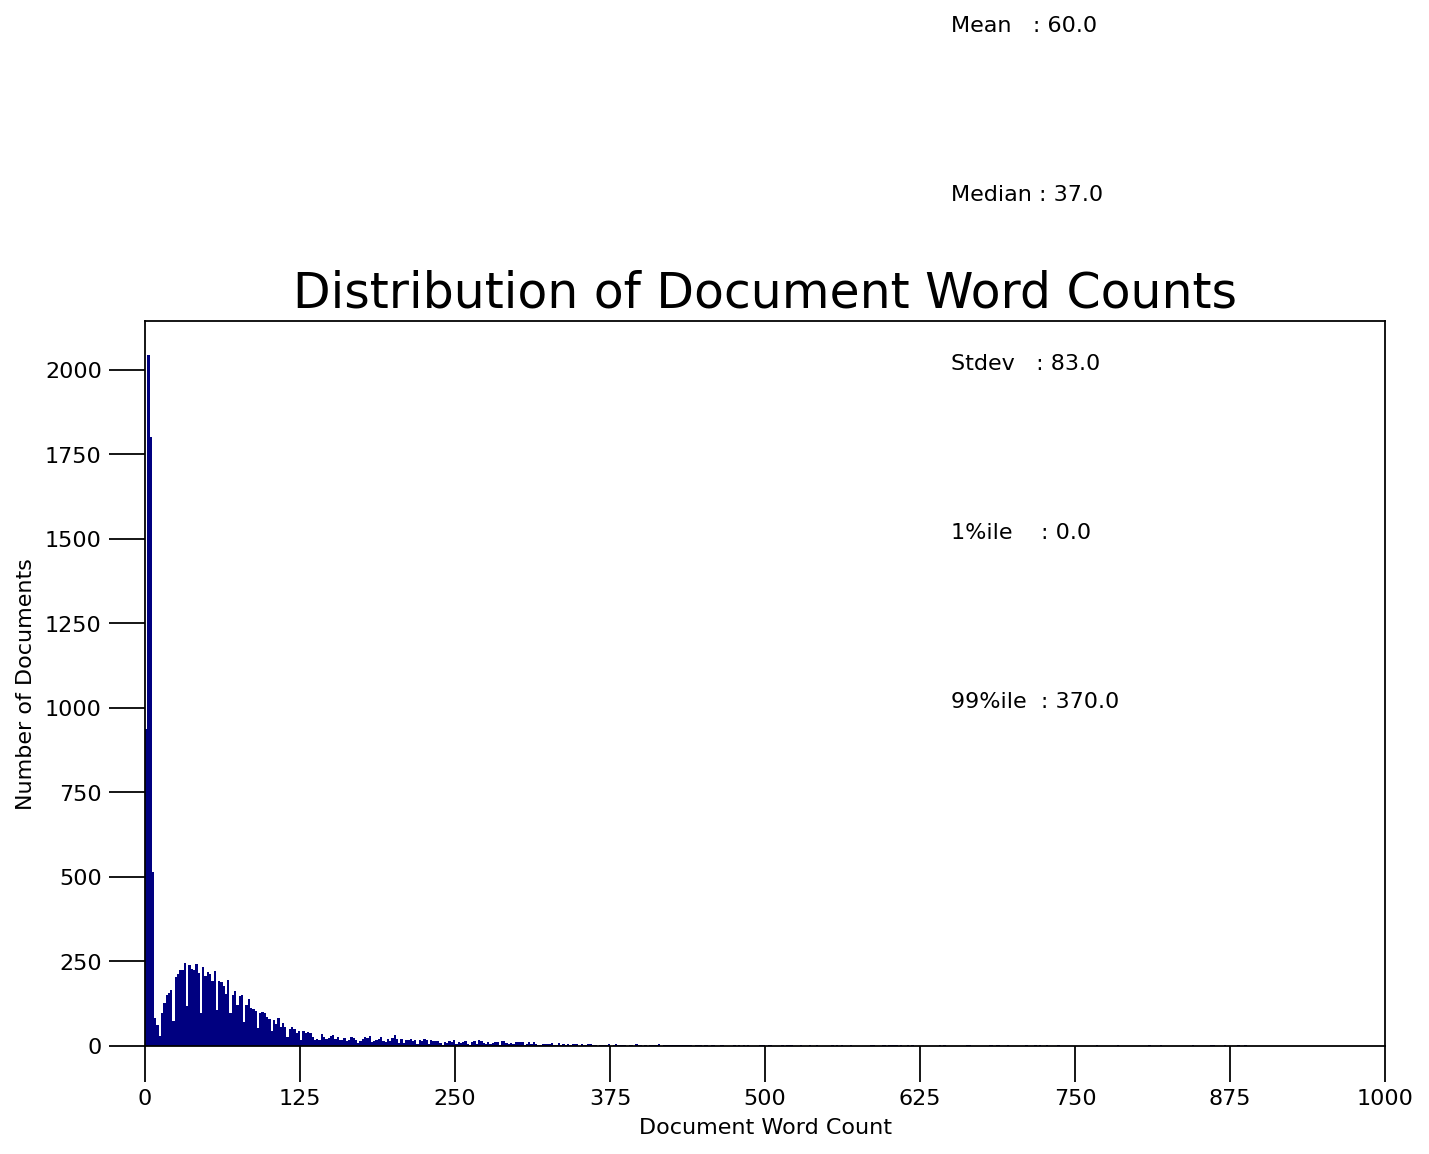

In [24]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(10,6), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(650, 3000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(650,  2500, "Median : " + str(round(np.median(doc_lens))))
plt.text(650,  2000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(650,  1500, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(650,  1000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

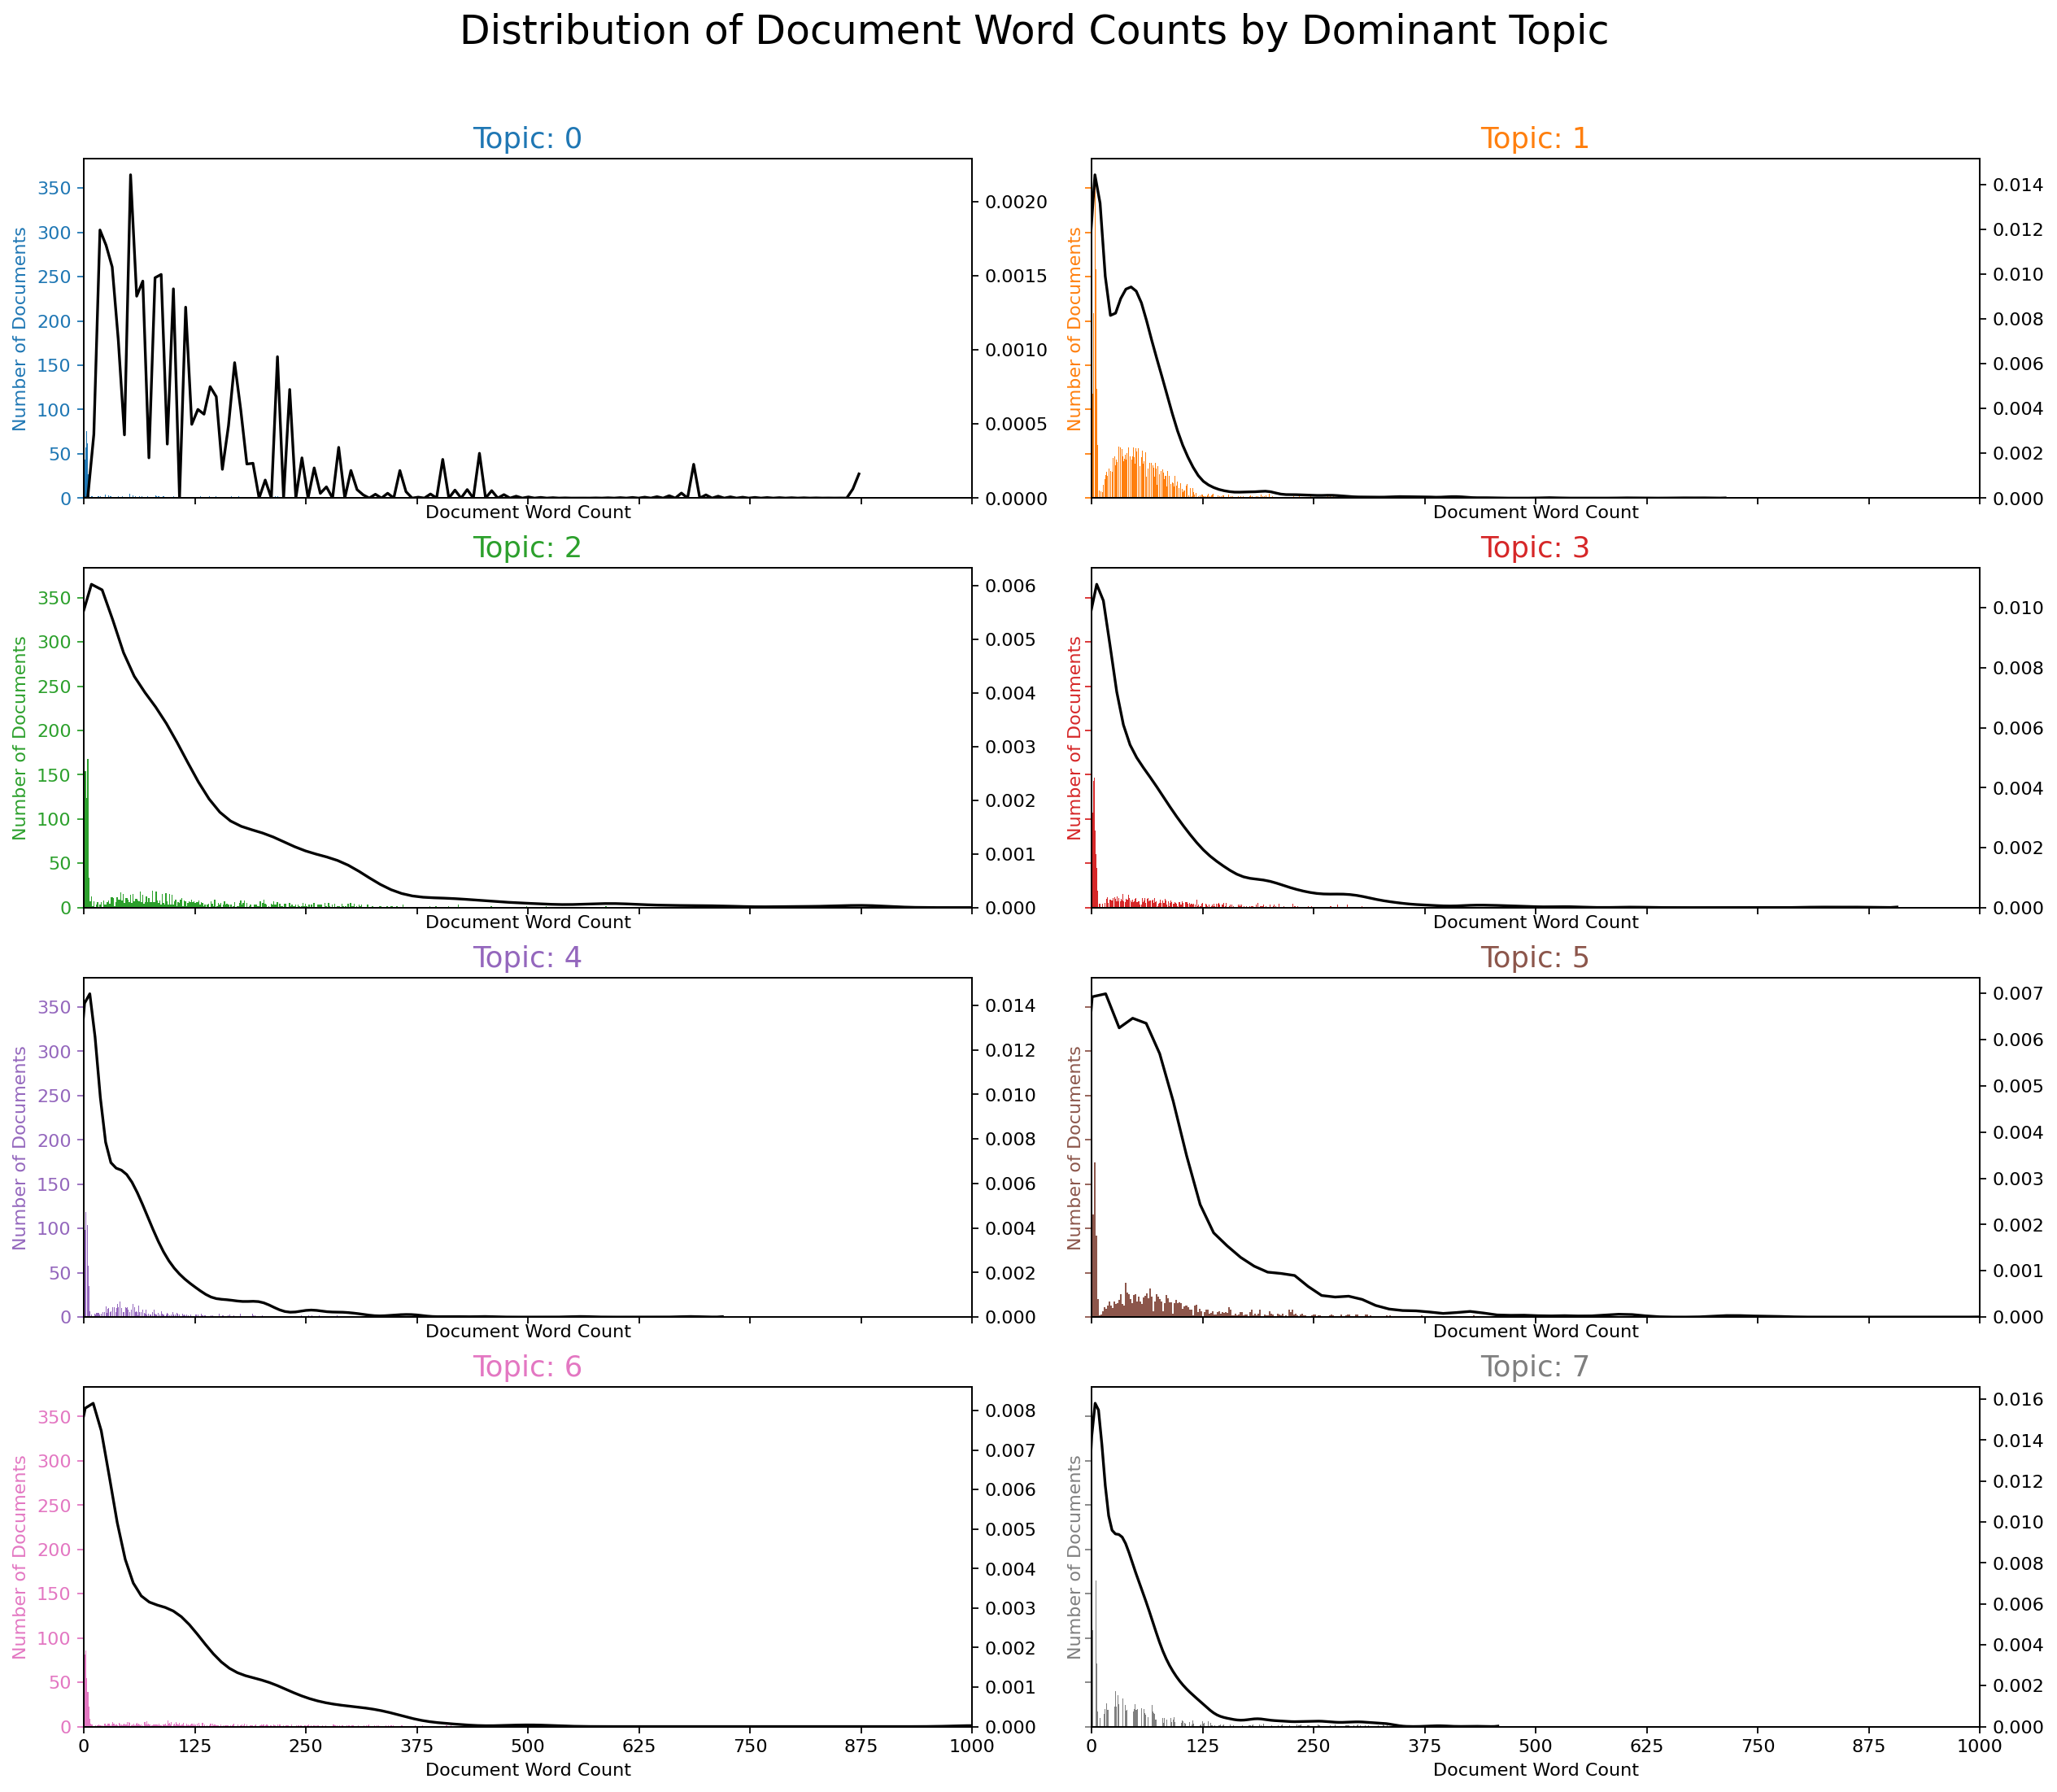

In [25]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(int(number_of_topic/2),2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Word Clouds of Top N Keywords in Each Topic

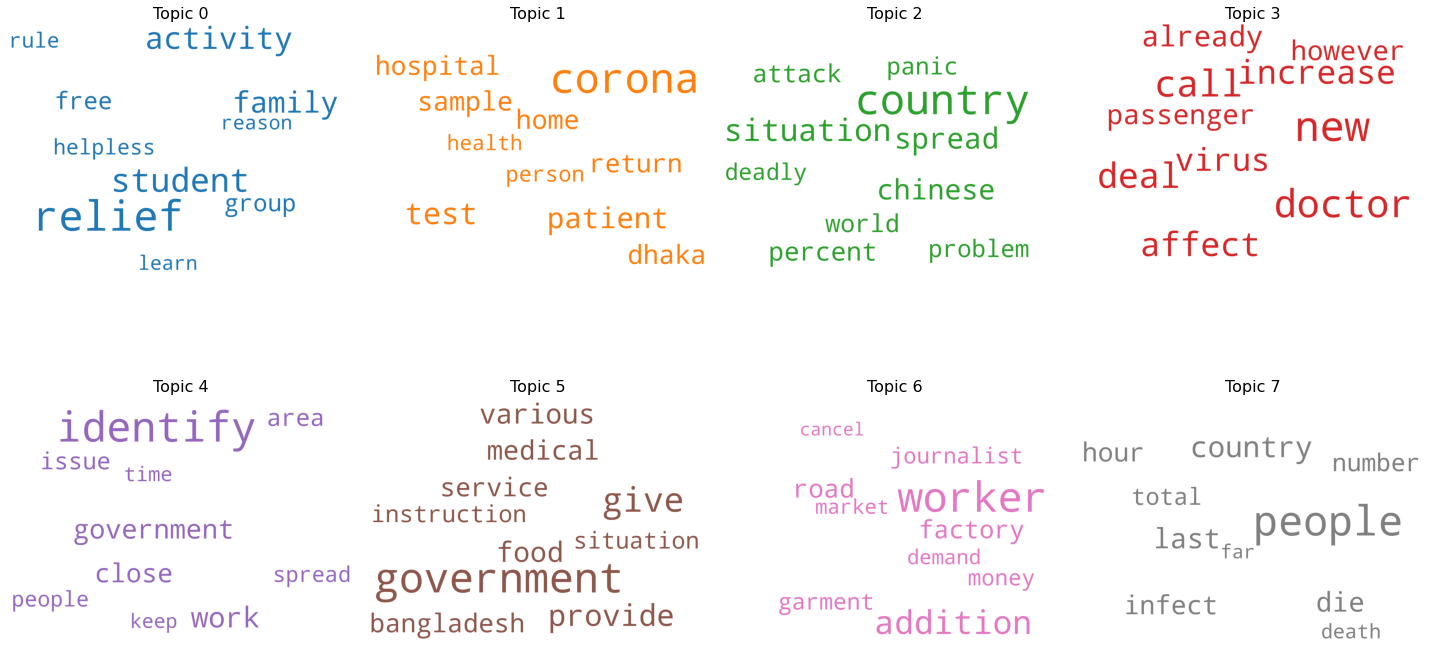

In [26]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, int(number_of_topic/2), figsize=(20,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

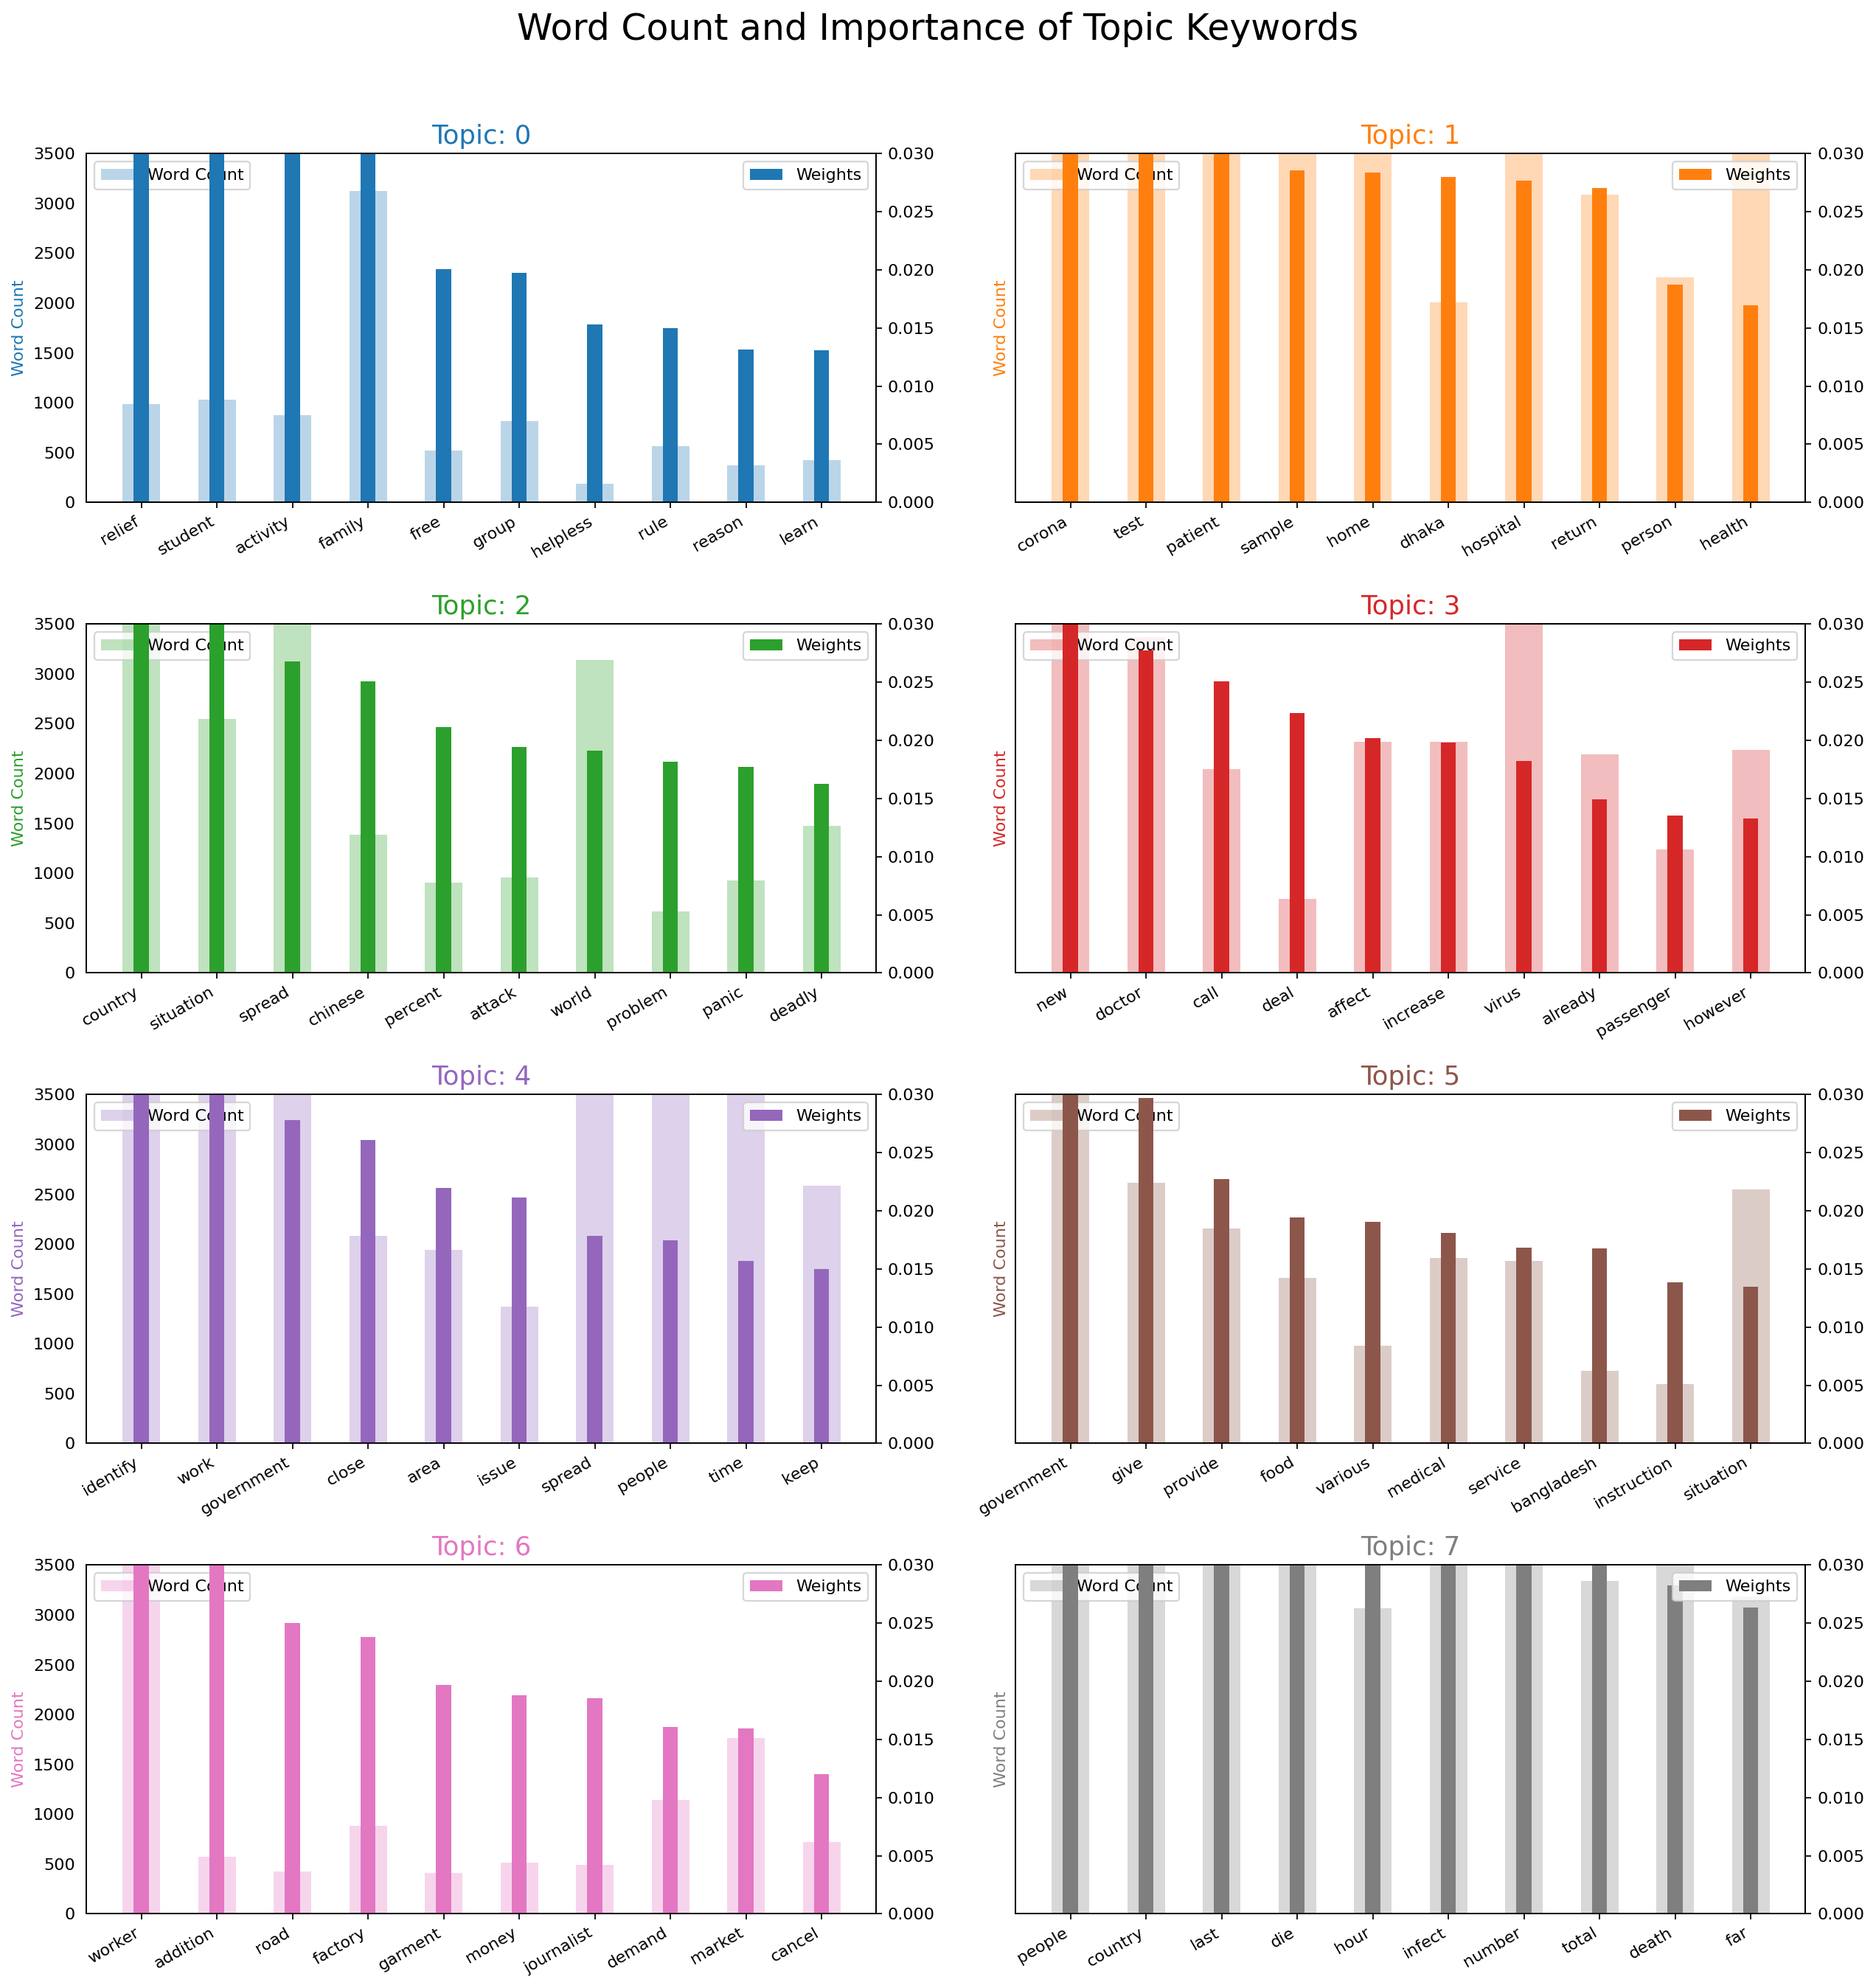

In [27]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(int(number_of_topic/2), 2, figsize=(16,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


# Sentence Chart Colored by Topic

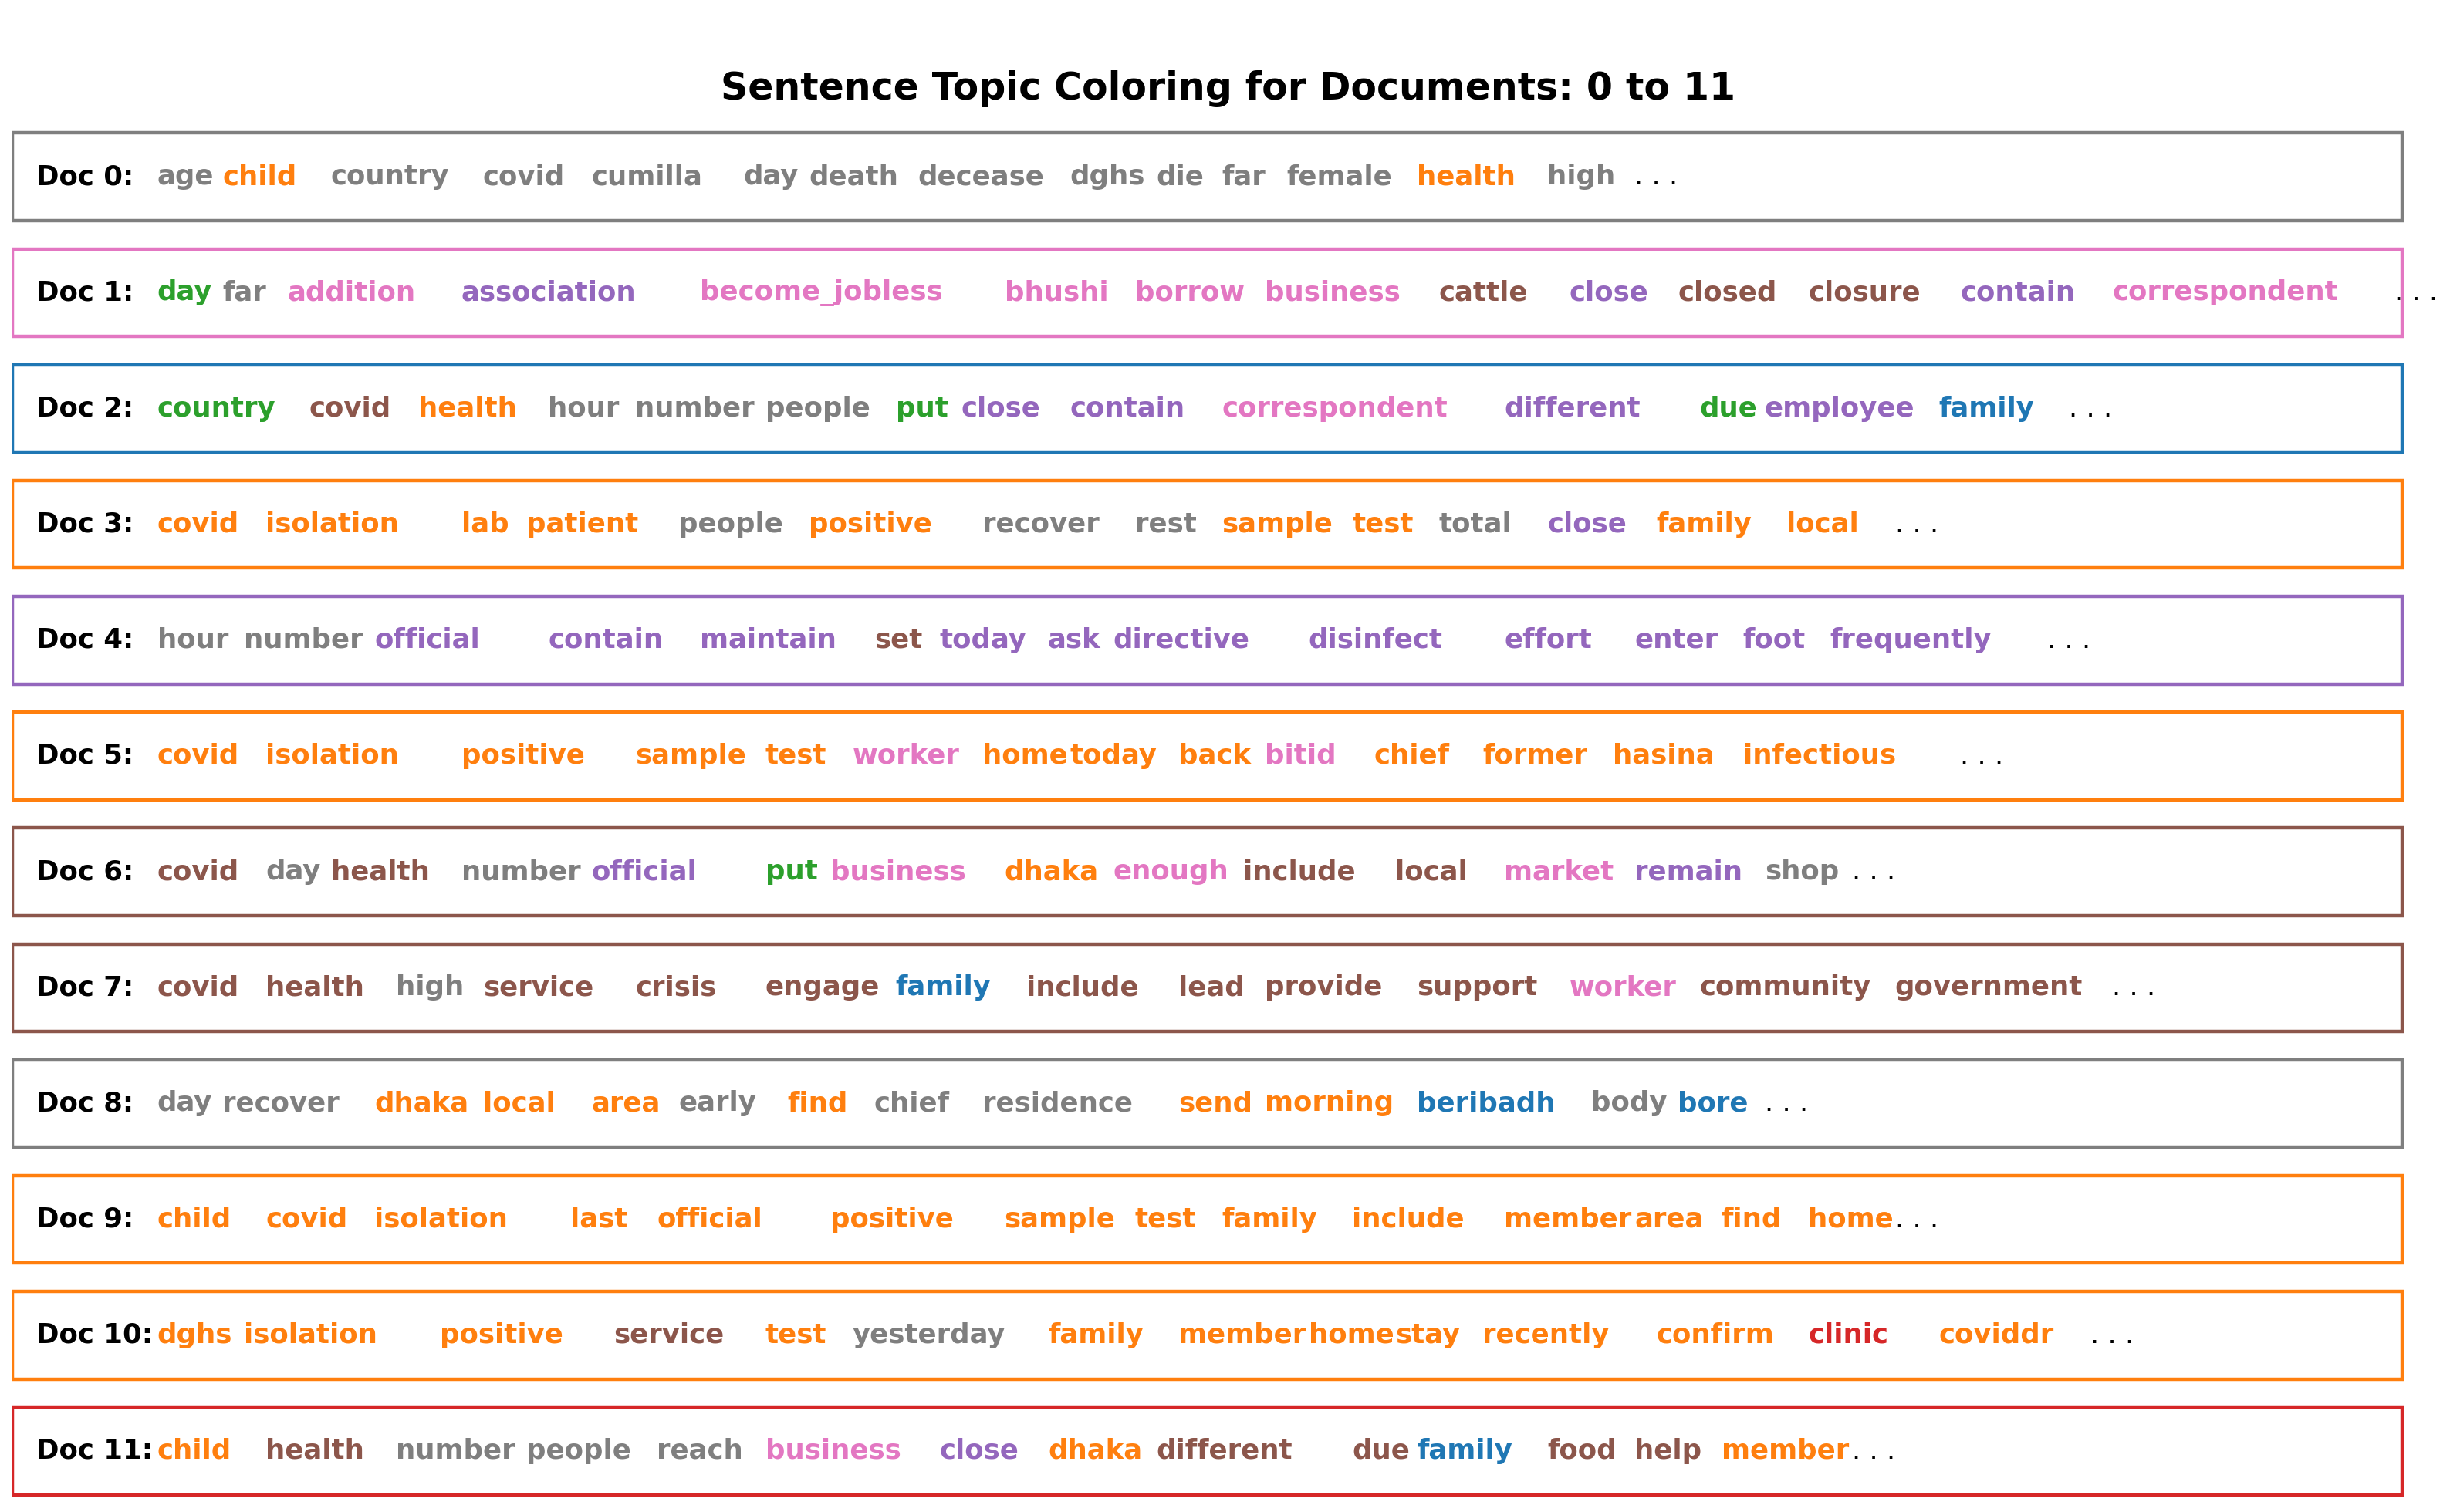

In [28]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    


# What are the most discussed topics in the documents?

In [29]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

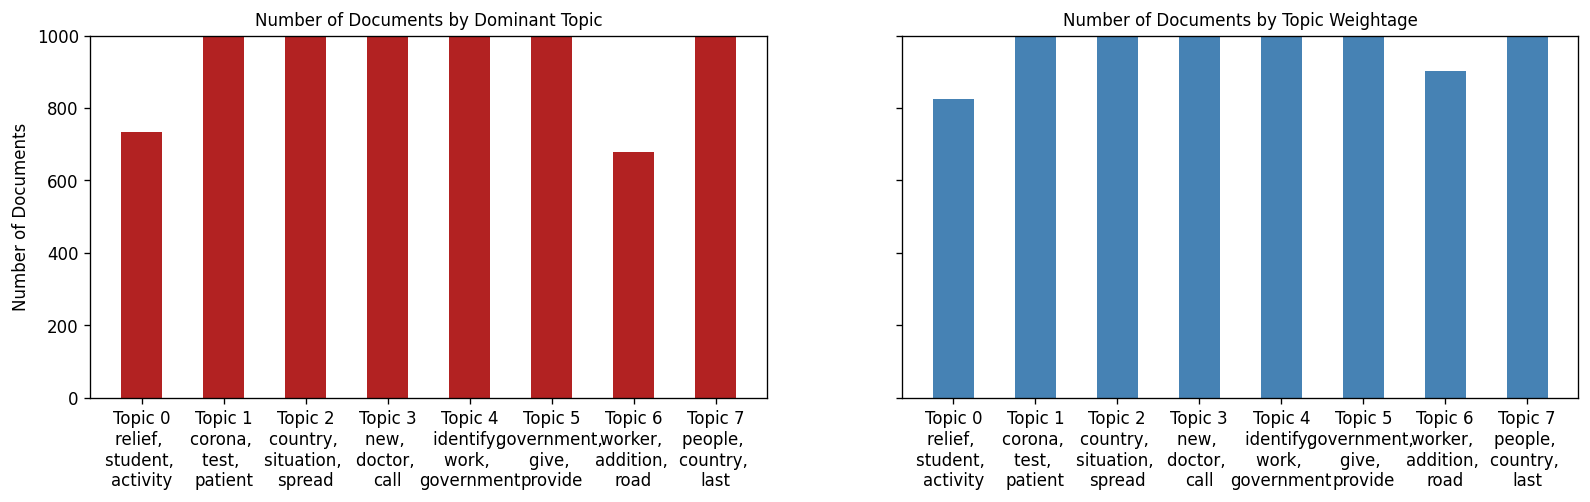

In [30]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

# t-SNE Clustering Chart

In [31]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = number_of_topic
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9770 samples in 0.016s...
[t-SNE] Computed neighbors for 9770 samples in 0.615s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9770
[t-SNE] Computed conditional probabilities for sample 2000 / 9770
[t-SNE] Computed conditional probabilities for sample 3000 / 9770
[t-SNE] Computed conditional probabilities for sample 4000 / 9770
[t-SNE] Computed conditional probabilities for sample 5000 / 9770
[t-SNE] Computed conditional probabilities for sample 6000 / 9770
[t-SNE] Computed conditional probabilities for sample 7000 / 9770
[t-SNE] Computed conditional probabilities for sample 8000 / 9770
[t-SNE] Computed conditional probabilities for sample 9000 / 9770
[t-SNE] Computed conditional probabilities for sample 9770 / 9770
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.677536
[t-SNE] KL divergence after 1000 iterations: 1.037288


# pyLDAVis

In [32]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.214516  0.262275       1        1  19.342878
7      0.250592 -0.283161       2        1  15.452662
3     -0.074662  0.092908       3        1  15.313108
5      0.015118  0.118913       4        1  14.077338
2     -0.071653 -0.156316       5        1  13.300856
4      0.090347  0.003486       6        1  10.505232
6     -0.216731 -0.044697       7        1   6.878772
0     -0.207527  0.006592       8        1   5.129150, topic_info=          Term          Freq         Total Category  logprob  loglift
25      people  23764.000000  23764.000000  Default  30.0000  30.0000
1177    corona  14645.000000  14645.000000  Default  29.0000  29.0000
784   identify   8221.000000   8221.000000  Default  28.0000  28.0000
2      country  18067.000000  18067.000000  Default  27.0000  27.0000
19        last   8495.000000   8495.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
8522     drink    232.007141    235.826065   Topic8  -5.3231   2.9539
71      family   1485.911499   3434.751953   Topic8  -3.4661   2.1323
1063     thing    293.599213    500.566101   Topic8  -5.0877   2.4367
271        way    275.641418   1786.135742   Topic8  -5.1508   1.1015
139       time    258.096863   5601.087891   Topic8  -5.2166  -0.1072

[346 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
491       3  0.998216       able
333       1  0.261049     accord
333       2  0.615472     accord
333       4  0.122379     accord
1251      4  0.704671     action
...     ...       ...        ...
147       7  0.999505     worker
1066      5  0.999253      world
1146      5  0.996144      worry
39        2  0.998769       year
40        2  0.996885  yesterday

[381 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 4, 6, 3, 5, 7, 1])

In [36]:
from gensim.models import CoherenceModel
#text_data = pd.read_pickle('text_data.pkl')

number_of_topics = [5,6,7,8,9,10,11,12,13,14,15]
perplexity_values = []
coherence_values = []
for k in number_of_topics:
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=k, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=10,
                                            passes=10,
                                            alpha='symmetric',
                                            per_word_topics=True)
  perplexity_values.append(lda_model.log_perplexity(corpus))
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=lda_model.id2word, coherence='c_v')
  coherence_values.append(coherence_model_lda.get_coherence())


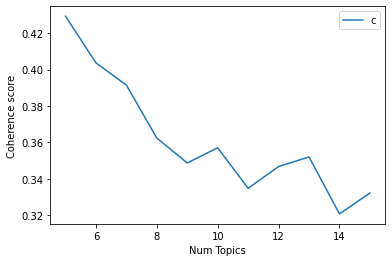

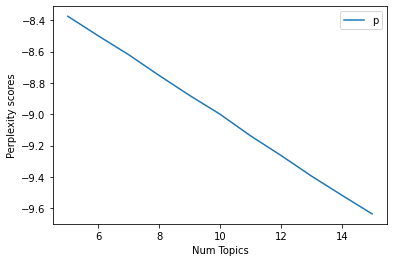

In [37]:
import matplotlib.pyplot as plt

plt.plot(number_of_topics, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

plt.plot(number_of_topics, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity scores")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
  # Topic with 8 numbers of topics

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [ ]:
import seaborn as sns
fiz = plt.figure(figsize=(15,30))
for i in range(8):
    df = pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')
    # df=df.sort_values('prob')
    
    plt.subplot(4,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    plt.xlabel('probability')
    
plt.show()